In [1]:
import os
import pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from pmdarima.arima import auto_arima, ndiffs
from pytrends.request import TrendReq

pytrends = TrendReq(hl='NL', tz=360)

C:\Users\31648\AppData\Local\Temp\ipykernel_27872\2383120745.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\31648\AppData\Local\Programs\Python\Python312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Time series are ever present in almost every corner of the internet. An interesting time series source to explore is Google Trends, where we can find the interest of any topic over time in Google.

### I picked up some random Netherlands related topics for this short notebook - Beer, Summer, and Sinterklaas.

In [2]:
kw = ['Bier', 'Zomer', 'Sinterklaas', 'Vakantie']
pytrends.build_payload(kw_list = kw, timeframe='2021-12-31 2023-12-31')
df = pytrends.interest_over_time()
df = df.drop(columns = ['isPartial'])

# Time series decomposition

<Axes: xlabel='date'>

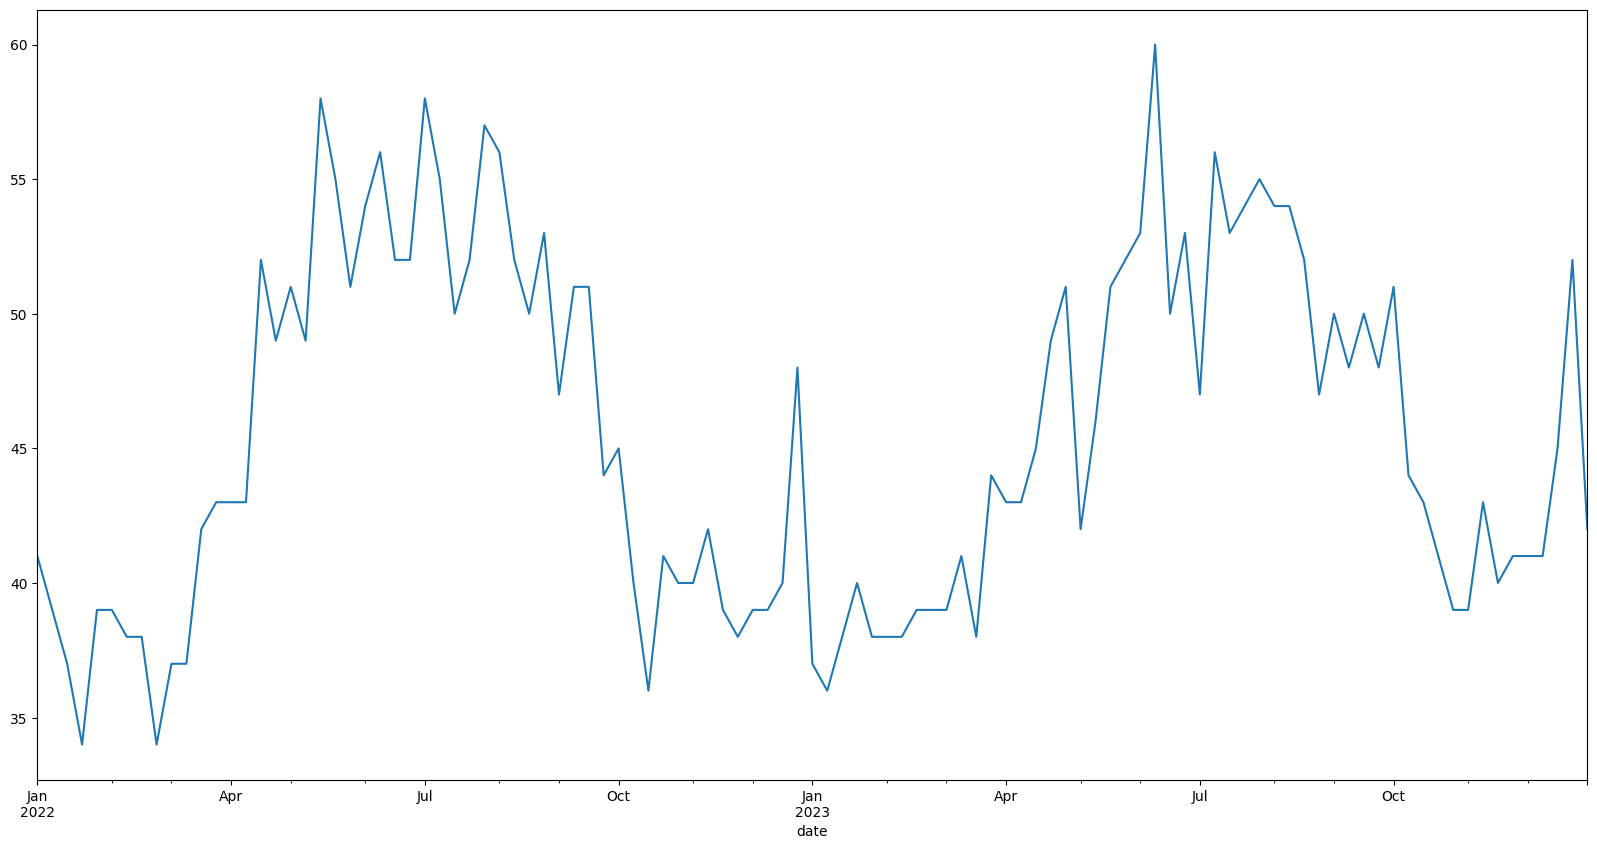

In [3]:
ts = df['Bier']
ts.plot(figsize=(20,10))

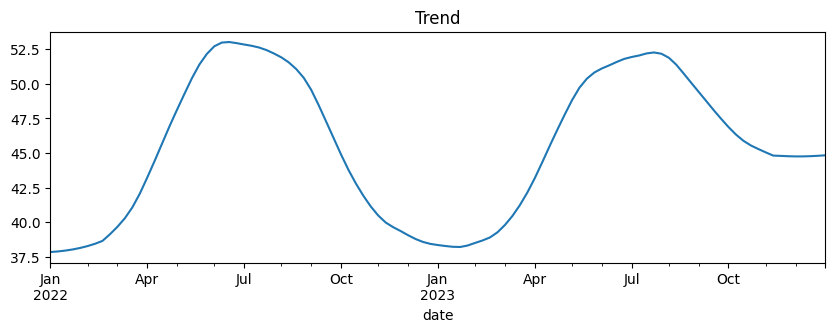

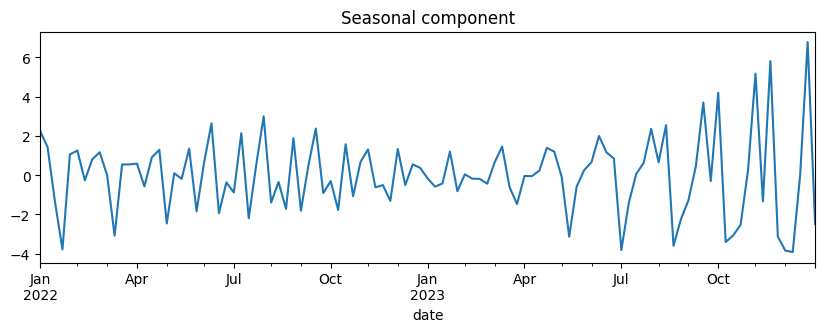

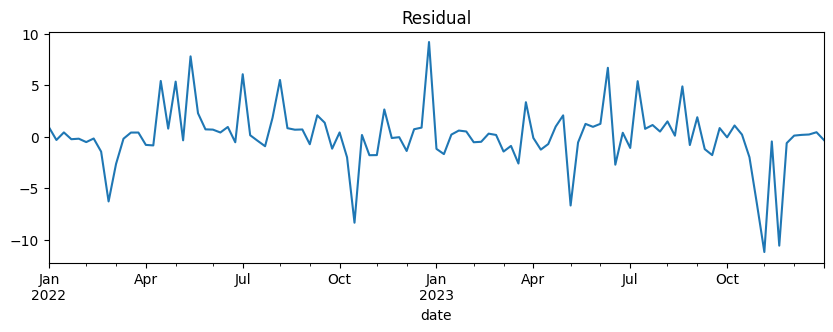

In [4]:
res = STL(ts, period = 7, robust = True).fit()
data = pd.concat([res.resid, res.trend, res.seasonal], axis = 1)

data['trend'].plot(title = 'Trend', figsize=(10,3))
plt.show()

data['season'].plot(title = 'Seasonal component', figsize=(10,3))
plt.show()

data['resid'].plot(title = 'Residual', figsize=(10,3))
plt.show()

The trend seems to be a smoother time series, as expected

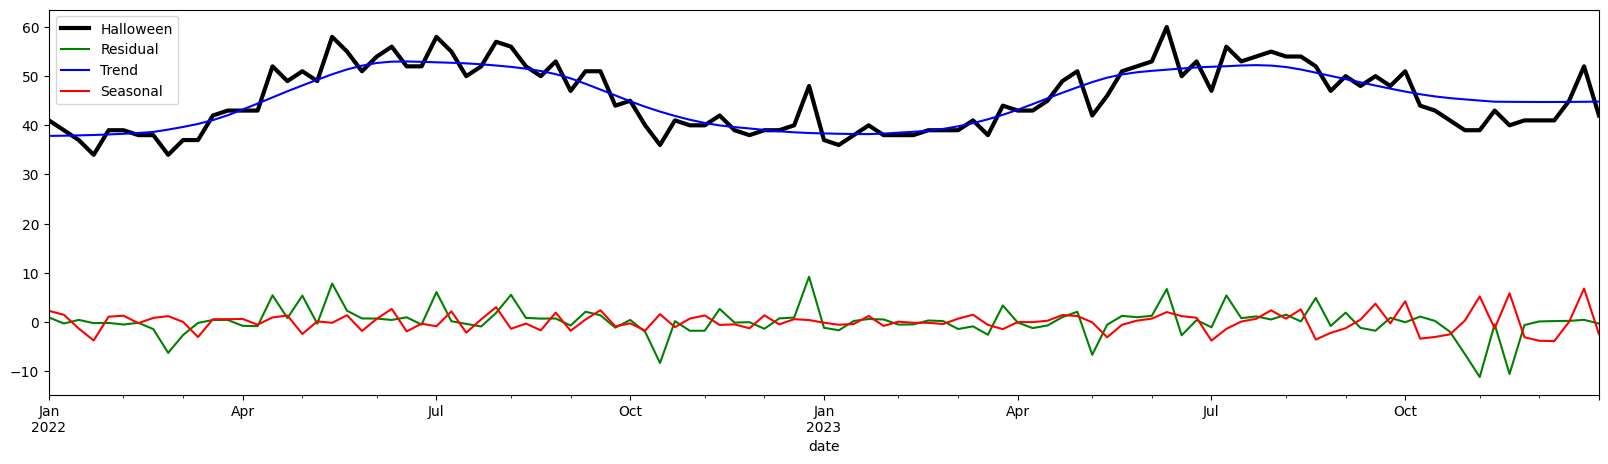

In [5]:
ts.plot(figsize=(20,10), lw = 3, color = 'black')
res.resid.plot(figsize=(20,5), color = 'green')
res.trend.plot(figsize=(20,5), color = 'blue')
res.seasonal.plot(figsize=(20,5), color = 'red')
plt.legend(["Halloween", "Residual", "Trend", "Seasonal"])

# Time series clustering

An interesting application on time series is to cluster time series that behave similarly over time.

In [6]:
model = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=10)
model.fit(df.transpose())
model.predict(df.transpose())

c:\Users\31648\AppData\Local\Programs\Python\Python312\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 4 1-dimensional timeseries
  warnings.warn(


array([1, 0, 0, 1], dtype=int64)

<Axes: xlabel='date'>

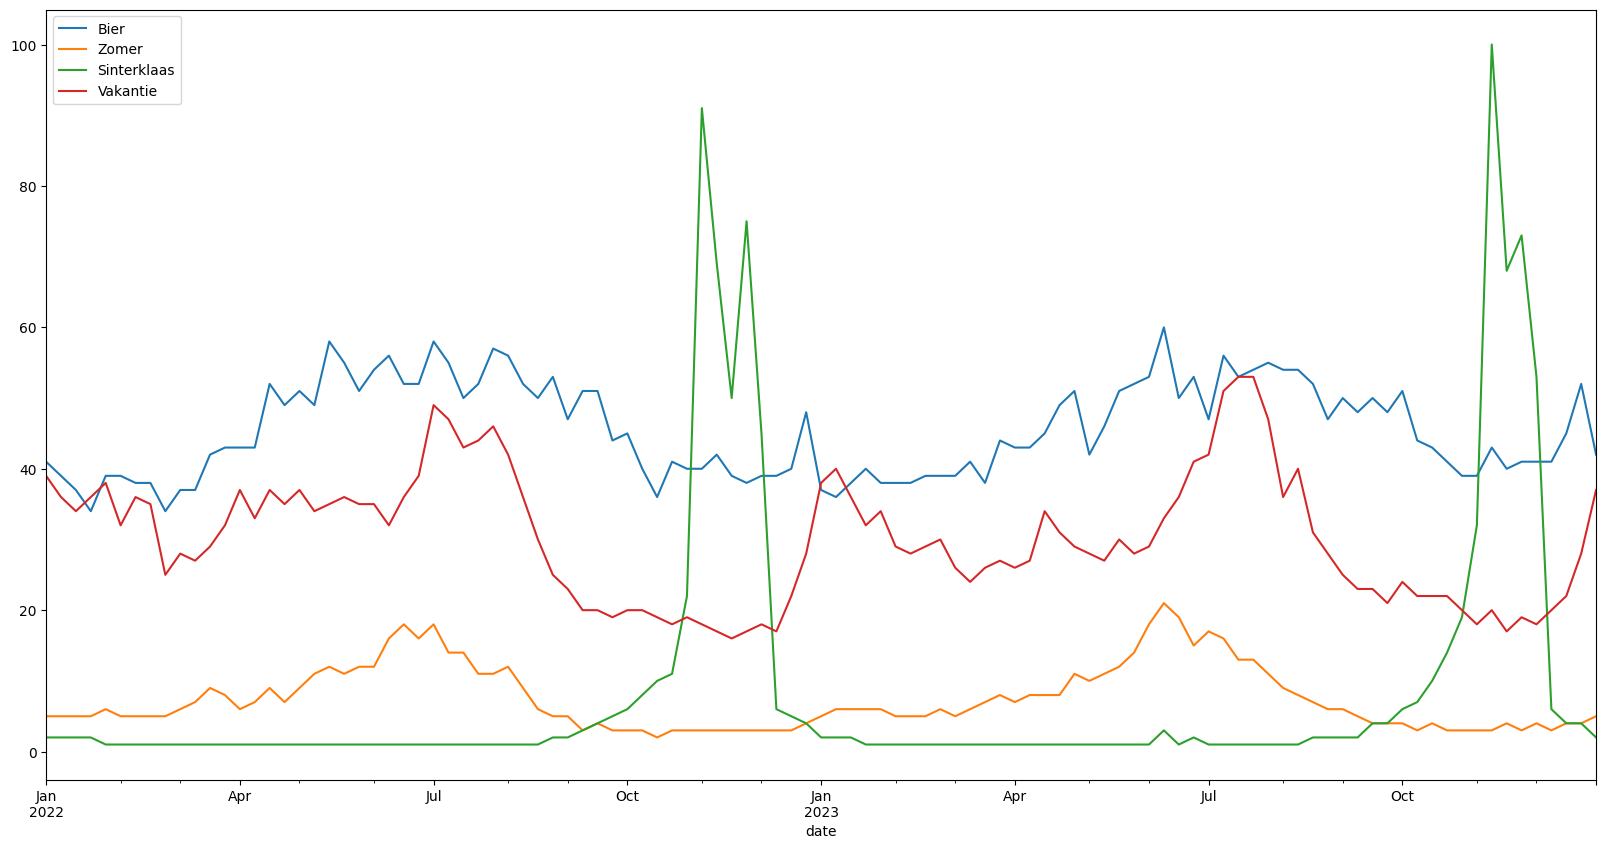

In [7]:
df.plot(figsize=(20,10))

In [8]:
model = TimeSeriesKMeans(n_clusters=2, metric="softdtw",
                         max_iter=20)
model.fit(df.transpose())
model.predict(df.transpose())

c:\Users\31648\AppData\Local\Programs\Python\Python312\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 4 1-dimensional timeseries
  warnings.warn(


array([0, 1, 1, 0], dtype=int64)

# Time series prediction

One of the most important applications of time series is prediction. There is a wide variety of models, but for stationary time series ARIMA(d,p,q) can be a solid option for short term predictions. Reent applications can also relax the assumption of homoscedastic error terms and allow correlation for the error between time periods, using ARIMA-GARCH models.

In [9]:
ts = df['Zomer']

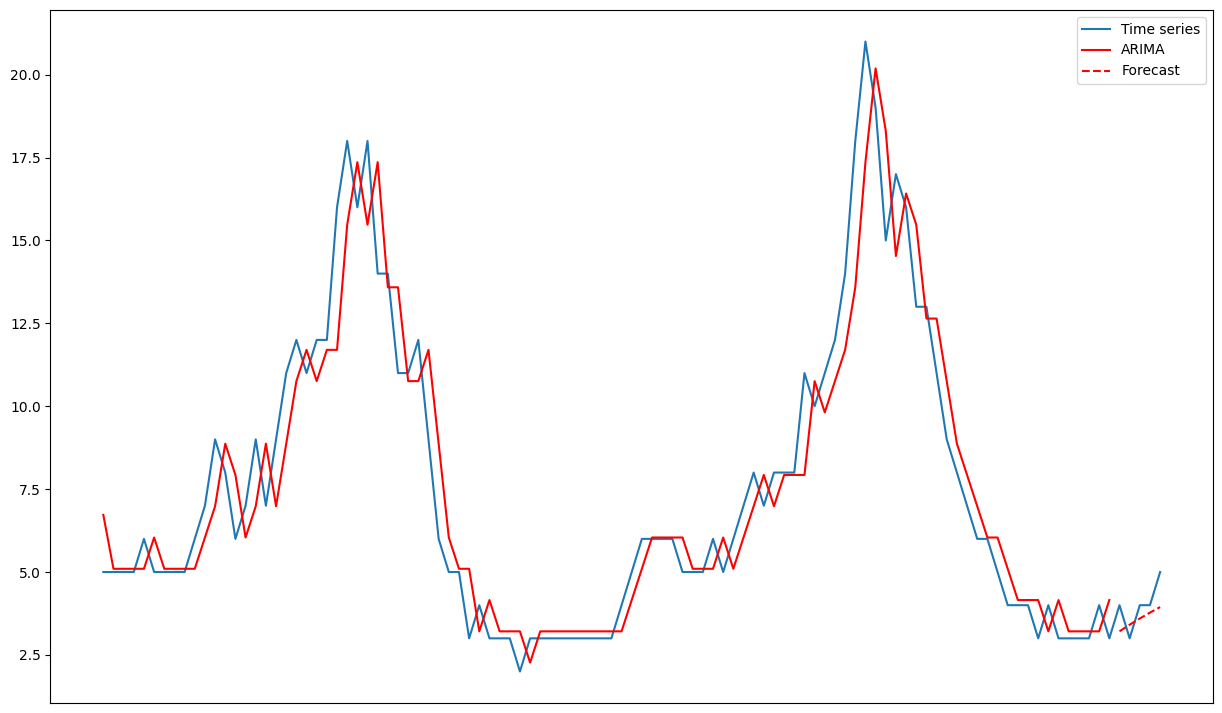

In [10]:
n = 5

ts_train = ts[0:-n]

d = ndiffs(ts_train)
model = auto_arima(ts_train, start_p = 0, max_p = 5, d = d, start_q = 0, max_q = 5).fit(ts_train)

arima = pd.Series(model.predict_in_sample(ts), index = ts.index)

pred = pd.Series(model.predict(n_periods=n), index = ts[-n:].index)

fig, ax = plt.subplots(figsize=(15,9))

ax.set_xticklabels([])
ax.set_xticks([])

ax.plot(ts.index, ts, label = 'Time series')
ax.plot(arima.index, arima, color = 'red', linestyle = 'solid', label = 'ARIMA')
ax.plot(pred.index, pred, color = 'red', linestyle = 'dashed', label = 'Forecast')

ax.legend()